#### Author: Matthew W. Boyce, PhD, 
#### Email: boyce.matthew@epa.gov

#### Version: 1.0 06-17-2021

#### Description:  
- This script compares the Local performance of the aggregate data DataFrame generated by the ReadAndProcessData notebook. For this comparison, Groups will be generated using ClassyFire descriptors prepared for each parent compound. The Groupings are visualized, and the primary descriptors (features present in at least 50% of the features per group) are listed. For each grouping, the coverage for each model is determined and the overall performance (Sensitivity and Precision) are compared. Radial plots summarize performance for each model.


#### Notes: This script uses os, pandas, numpy, matplotlib, rdkit, scipy, and a python script of custom functions called model_comp

#### Potential issues: *None known*

#### Updates: Edited and revised by Grace Patlewicz, PI and corresponding author of the associated manuscript

In [1]:
import numpy as np
import os as os
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw

from IPython.core.display import HTML

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
TOP = os.getcwd().replace('notebooks', '')

In [3]:
raw_dat_dir = TOP + 'data/raw/'
processed_dat_dir = TOP + 'data/processed/'
interim_dat_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'
external_dir = TOP + 'data/external/'

In [4]:
import sys

sys.path.append(TOP + 'src/data/')

from model_comp import *

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
classyFireDF = pd.read_csv(raw_dat_dir+'classyFire_ExpoCast.csv')
DTXSIDList = pd.read_csv(processed_dat_dir+"Processed_CompToxList_v1.csv", header = 0)[['DTXSID', 'PREFERRED_NAME', 'QSAR_READY_SMILES']]
aggDataDF = pd.read_csv(processed_dat_dir+"Cleaned_AggregateData_031221_sorted.csv")

In [19]:
modelList = ['TB_ivt','TB_iv', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro', 'SyGMa', 'CTS'] 

## Generate Groupings

In [8]:
classyFireDF['DTXSID'] = [DTXSIDList.loc[int(value.split('-')[1])-1, 'DTXSID'] for value in classyFireDF['CompoundID']]
classyFireDF

,CompoundID,ChemOntID,ParentName,DTXSID
0,Q5233679-1,CHEMONTID:0003968,Dinitroanilines,DTXSID0044151
1,Q5233679-1,CHEMONTID:0000036,Nitrobenzenes,DTXSID0044151
2,Q5233679-1,CHEMONTID:0004612,Nitroaromatic compounds,DTXSID0044151
3,Q5233679-1,CHEMONTID:0003633,"Propargyl-type 1,3-dipolar organic compounds",DTXSID0044151
4,Q5233679-1,CHEMONTID:0001508,Organic oxoazanium compounds,DTXSID0044151
...,...,...,...,...
286,Q5233679-36,CHEMONTID:0001661,Secondary alcohols,DTXSID7020762
287,Q5233679-36,CHEMONTID:0004150,Hydrocarbon derivatives,DTXSID7020762
288,Q5233679-37,CHEMONTID:0000118,Ketones,DTXSID8021482
289,Q5233679-37,CHEMONTID:0003940,Organic oxides,DTXSID8021482


In [9]:
fpCatalog = pd.Series(list(set(classyFireDF['ParentName'])))
fpCatalog

0                           Organochlorides
1                            Beta-diketones
2                  Heteroaromatic compounds
3                    Carboxylic acid esters
4                 Organopnictogen compounds
                       ...                 
103                      Carboximidic acids
104                                Styrenes
105    Monocarboxylic acids and derivatives
106                     Organic zwitterions
107                      Carbonyl compounds
Length: 108, dtype: object

In [10]:
fpMatrix = np.zeros([len(DTXSIDList), len(fpCatalog)], dtype = int)

for idx, DTXSID in enumerate(DTXSIDList['DTXSID']):
    fpList = []
    DTXSIDfilter = classyFireDF['DTXSID'] == DTXSID
    for fp in fpCatalog:
        fpList += [int(fp in classyFireDF.loc[DTXSIDfilter,'ParentName'].values)]
    fpMatrix[idx] = fpList
    
fpMatrix

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

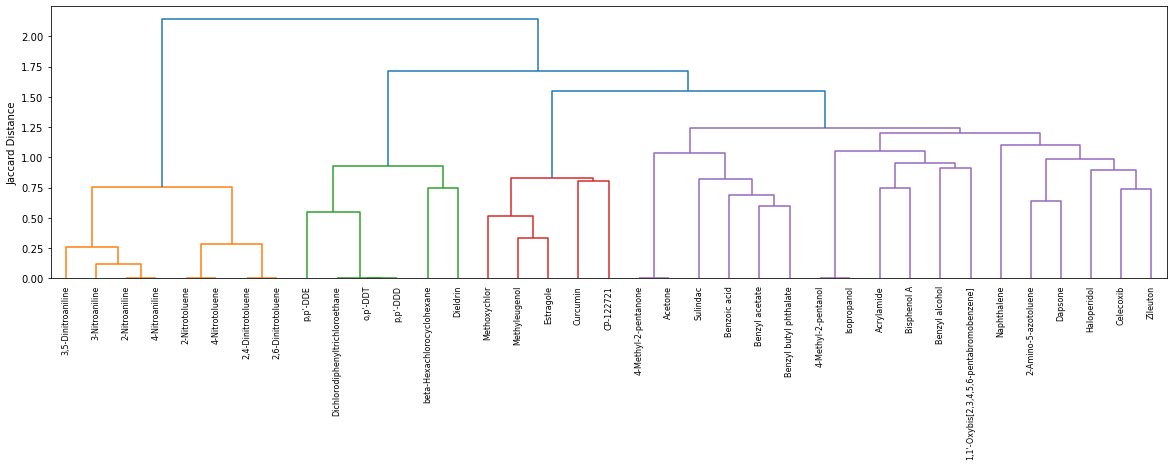

In [12]:
fpDist = pdist(fpMatrix, metric = 'jaccard')
parentGroup = hc.linkage(fpDist, method = 'ward')
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
plot = hc.dendrogram(parentGroup, labels = DTXSIDList['PREFERRED_NAME'].to_list(), leaf_rotation = 90)
plt.ylabel('Jaccard Distance')
plt.savefig(figures_dir+'similarity_ClassyFire_031221.png', transparent = True, bbox_inches='tight')

In [13]:
groups = 5
groupCut = hc.cut_tree(parentGroup, groups)
classyFireGroup = {'DTXSID' : np.frompyfunc(list, 0, 1)(np.empty((groups), dtype=object)), 'MOL': np.frompyfunc(list, 0, 1)(np.empty((groups), dtype=object))}
for idx, value in enumerate(groupCut):
    classyFireGroup['DTXSID'][groupCut[idx][0]] += [DTXSIDList.loc[idx, 'DTXSID']]        
    classyFireGroup['MOL'][groupCut[idx][0]] += [Chem.MolFromSmiles(DTXSIDList.loc[idx, 'QSAR_READY_SMILES'])]

Group:  1


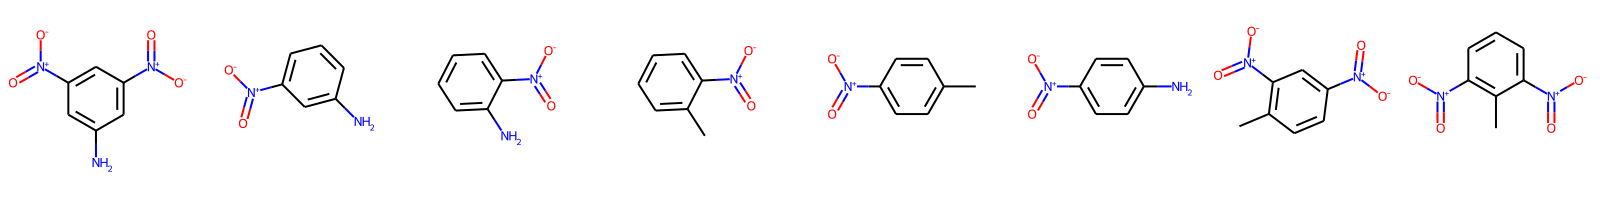

Group:  2


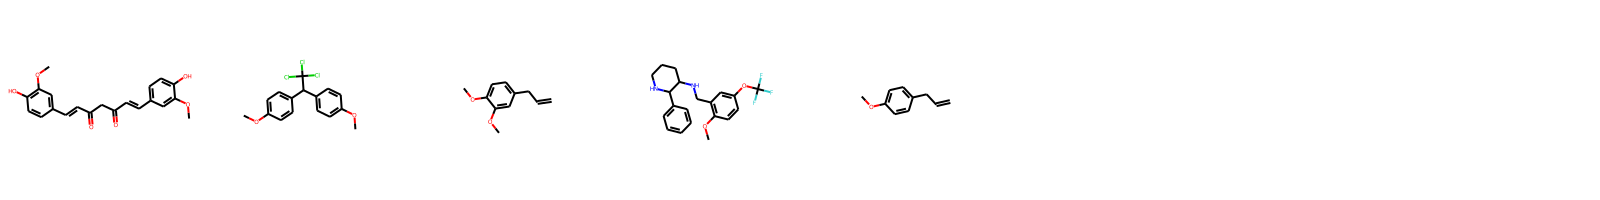

Group:  3


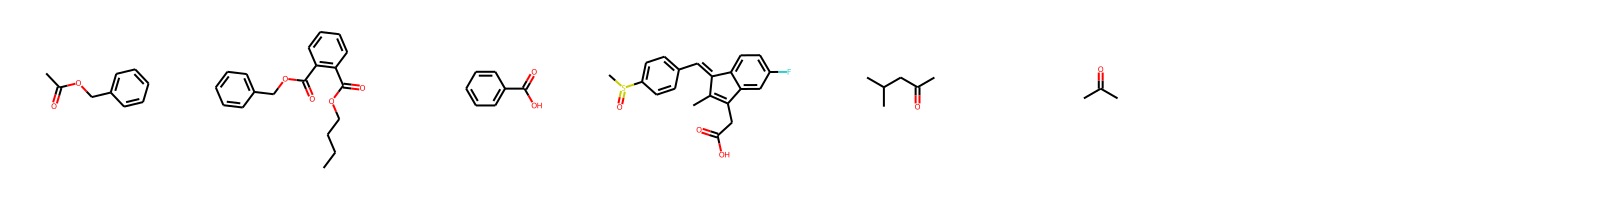

Group:  4


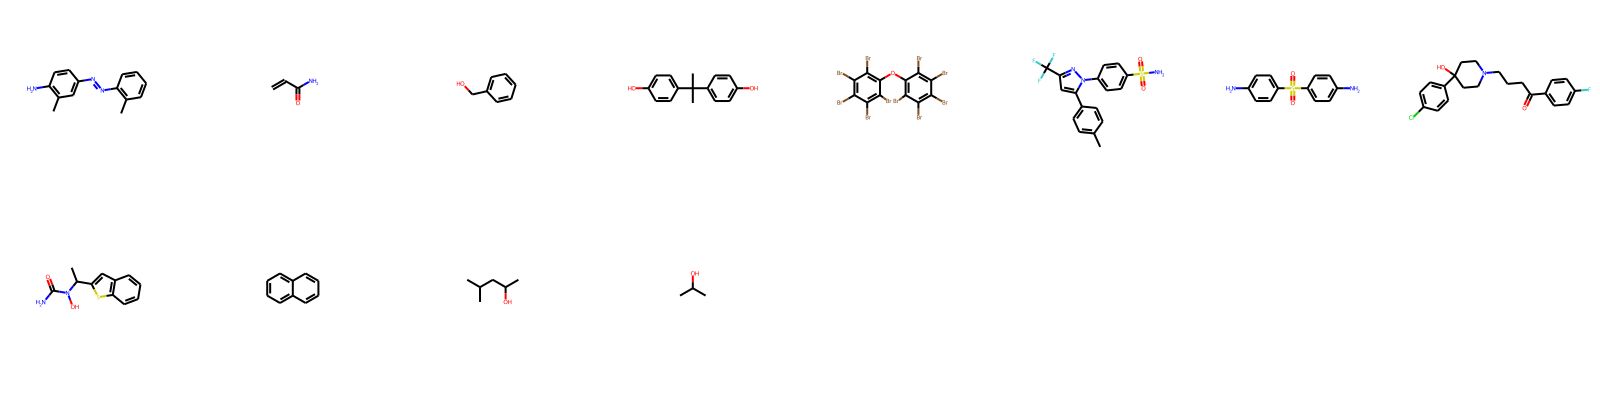

Group:  5


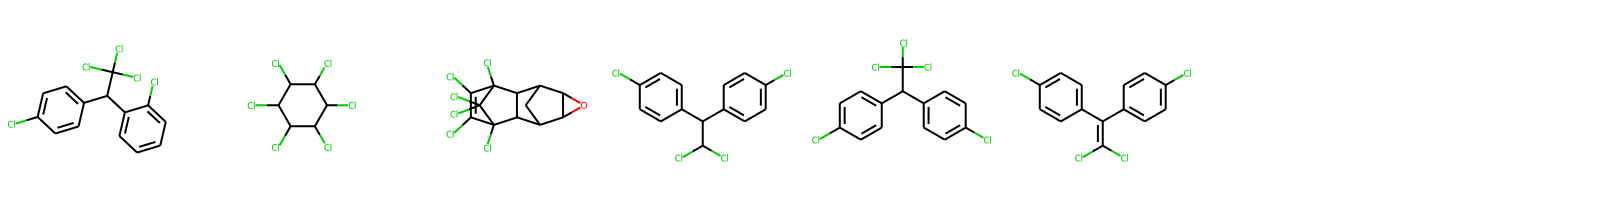

In [14]:
for idx, groups in enumerate(classyFireGroup['MOL']):
    print('Group: ', idx+1)
    display(Draw.MolsToGridImage(groups, molsPerRow=8, subImgSize=(200, 200)))

#### Find the primary ClassyFire descriptors used to group each set of chemicals

In [15]:
groupIdentifierDF = pd.DataFrame(columns = {'GroupIdx', 'ID', 'Count'})

for idx, group in enumerate(classyFireGroup['DTXSID']):
    classyFireIDs = classyFireDF.loc[classyFireDF['DTXSID'].isin(group), 'ParentName']
    for ID in set(classyFireIDs):
        idWeight = sum(classyFireIDs == ID)/len(group)
        if idWeight >= .50:
            groupIdentifierDF = groupIdentifierDF.append({'GroupIdx': idx, 'ID' : ID, 'Count' : idWeight}, ignore_index = True)
groupIdentifierDF.drop_duplicates(subset = 'ID', inplace = True)

In [16]:
groupIdentifierDF

,Count,GroupIdx,ID
0,0.500000,0,Organonitrogen compounds
1,0.500000,0,Primary amines
2,1.000000,0,Organopnictogen compounds
3,1.000000,0,Nitrobenzenes
4,1.000000,0,Organic oxoazanium compounds
5,1.000000,0,Organic oxides
6,1.000000,0,"Propargyl-type 1,3-dipolar organic compounds"
7,1.000000,0,Nitroaromatic compounds
8,1.000000,0,Hydrocarbon derivatives
9,1.000000,1,Anisoles


## Performance Per Grouping <a class="anchor" id="fifth-bullet"></a>

In [20]:
performanceMap = {}

In [21]:
for idx, group in enumerate(classyFireGroup['DTXSID']):
    aggGroup = aggDataDF[aggDataDF['DTXSID'].isin(group)]
    performanceMap['Group'+ str(idx)] = pd.DataFrame(data = None, columns=['Model','Total','Unique'] + modelList)
    performanceMap['Group'+ str(idx)]['Model'] = modelList
    performanceMap['Group'+ str(idx)]['Total'] = list(aggGroup[modelList].sum(axis=0))
    performanceMap['Group'+ str(idx)]['Unique'] = [sum((aggGroup[match] == 1.0) & (aggGroup[modelList].sum(axis = 1) == 1)) for match in modelList]
    performanceMap['Group'+ str(idx)]['Precision'] = [calcPrecision(aggGroup, x) for x in modelList]
    performanceMap['Group'+ str(idx)]['Sensitivity'] = [calcSensitivity(aggGroup, x) for x in modelList]

    for model in modelList:
        performanceMap['Group'+ str(idx)].loc[:,model] = [round((aggGroup[model]
                                                                  [(aggGroup[model]==1.0) & (aggGroup[match] == 1.0)].sum()*100 / 
                                                                  performanceMap['Group'+ str(idx)]['Total'][modelList.index(model)]),2) for match in modelList]


In [22]:
performanceMap['Group0']

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity
0,TB_ivt,41.0,0,100.00,48.94,34.92,2.21,20.72,56.94,3.77,35.29,0.268,0.314
1,TB_iv,47.0,2,56.10,100.00,34.92,1.10,40.54,31.94,3.77,36.47,0.170,0.229
2,Meteor,63.0,0,53.66,46.81,100.00,3.15,30.63,37.50,6.74,31.76,0.143,0.257
3,BioTransformer,634.0,404,34.15,14.89,31.75,100.00,9.01,27.78,25.26,9.41,0.011,0.200
4,TIMES_InVivo,111.0,12,56.10,95.74,53.97,1.58,100.00,38.89,9.94,36.47,0.099,0.314
5,TIMES_InVitro,72.0,10,100.00,48.94,42.86,3.15,25.23,100.00,5.83,35.29,0.167,0.343
6,SyGMa,875.0,544,80.49,70.21,93.65,34.86,78.38,70.83,100.00,37.65,0.018,0.457
7,CTS,85.0,42,73.17,65.96,42.86,1.26,27.93,41.67,3.66,100.00,0.094,0.229


In [23]:
performanceMap['Group1']

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity
0,TB_ivt,44.0,0,100.00,64.58,22.47,8.05,23.85,72.13,1.58,25.96,0.295,0.232
1,TB_iv,48.0,1,70.45,100.00,24.72,7.47,36.15,50.82,1.78,25.96,0.229,0.196
2,Meteor,89.0,15,45.45,45.83,100.00,18.39,26.15,36.07,4.09,22.12,0.157,0.232
3,BioTransformer,174.0,98,31.82,27.08,35.96,100.00,30.77,29.51,4.22,14.42,0.069,0.214
4,TIMES_InVivo,130.0,27,70.45,97.92,38.20,22.99,100.00,65.57,5.34,25.96,0.085,0.196
5,TIMES_InVitro,61.0,4,100.00,64.58,24.72,10.34,30.77,100.00,2.44,25.96,0.213,0.232
6,SyGMa,1517.0,1367,54.55,56.25,69.66,36.78,62.31,60.66,100.00,34.62,0.011,0.250
7,CTS,104.0,53,61.36,56.25,25.84,8.62,20.77,44.26,2.37,100.00,0.096,0.179


In [24]:
performanceMap['Group2']

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity
0,TB_ivt,26.0,0,100.00,42.22,19.18,0.45,19.39,86.67,1.81,31.58,0.462,0.353
1,TB_iv,45.0,0,73.08,100.00,28.77,0.23,45.92,63.33,3.05,33.33,0.289,0.382
2,Meteor,73.0,20,53.85,46.67,100.00,0.68,33.67,53.33,5.65,35.09,0.219,0.471
3,BioTransformer,441.0,291,7.69,2.22,4.11,100.00,5.10,10.00,16.95,8.77,0.005,0.059
4,TIMES_InVivo,98.0,19,73.08,100.00,45.21,1.13,100.00,76.67,6.78,33.33,0.163,0.471
5,TIMES_InVitro,30.0,0,100.00,42.22,21.92,0.68,23.47,100.00,2.26,31.58,0.400,0.353
6,SyGMa,885.0,655,61.54,60.00,68.49,34.01,61.22,66.67,100.00,49.12,0.018,0.471
7,CTS,57.0,23,69.23,42.22,27.40,1.13,19.39,60.00,3.16,100.00,0.246,0.412


In [25]:
performanceMap['Group3']

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity
0,TB_ivt,50.0,0,100.0,53.66,4.43,1.13,18.80,63.29,1.42,18.08,0.300,0.206
1,TB_iv,41.0,1,44.0,100.00,4.43,0.97,34.19,27.85,0.89,11.30,0.317,0.191
2,Meteor,474.0,389,42.0,51.22,100.00,1.99,38.46,36.71,3.42,12.99,0.055,0.265
3,BioTransformer,1863.0,1551,42.0,43.90,7.81,100.00,35.90,37.97,16.47,22.60,0.009,0.221
4,TIMES_InVivo,117.0,19,44.0,97.56,9.49,2.25,100.00,51.90,3.19,11.30,0.162,0.279
5,TIMES_InVitro,79.0,6,100.0,53.66,6.12,1.61,35.04,100.00,2.48,18.08,0.253,0.279
6,SyGMa,1694.0,1346,48.0,36.59,12.24,14.98,46.15,53.16,100.00,27.12,0.012,0.309
7,CTS,177.0,104,64.0,48.78,4.85,2.15,17.09,40.51,2.83,100.00,0.079,0.191


In [26]:
performanceMap['Group4']

,Model,Total,Unique,TB_ivt,TB_iv,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity
0,TB_ivt,33.0,0,100.00,32.73,20.00,3.12,15.79,80.49,4.10,4.08,0.152,0.086
1,TB_iv,55.0,0,54.55,100.00,26.67,1.99,48.25,53.66,2.46,4.08,0.218,0.207
2,Meteor,15.0,2,9.09,7.27,100.00,2.84,6.14,9.76,4.51,2.04,0.133,0.034
3,BioTransformer,352.0,212,33.33,12.73,66.67,100.00,14.91,31.71,51.64,28.57,0.003,0.017
4,TIMES_InVivo,114.0,45,54.55,100.00,46.67,4.83,100.00,63.41,5.33,4.08,0.114,0.224
5,TIMES_InVitro,41.0,0,100.00,40.00,26.67,3.69,22.81,100.00,4.92,4.08,0.195,0.138
6,SyGMa,244.0,113,30.30,10.91,73.33,35.80,11.40,29.27,100.00,18.37,0.016,0.069
7,CTS,49.0,34,6.06,3.64,6.67,3.98,1.75,4.88,3.69,100.00,0.000,0.000


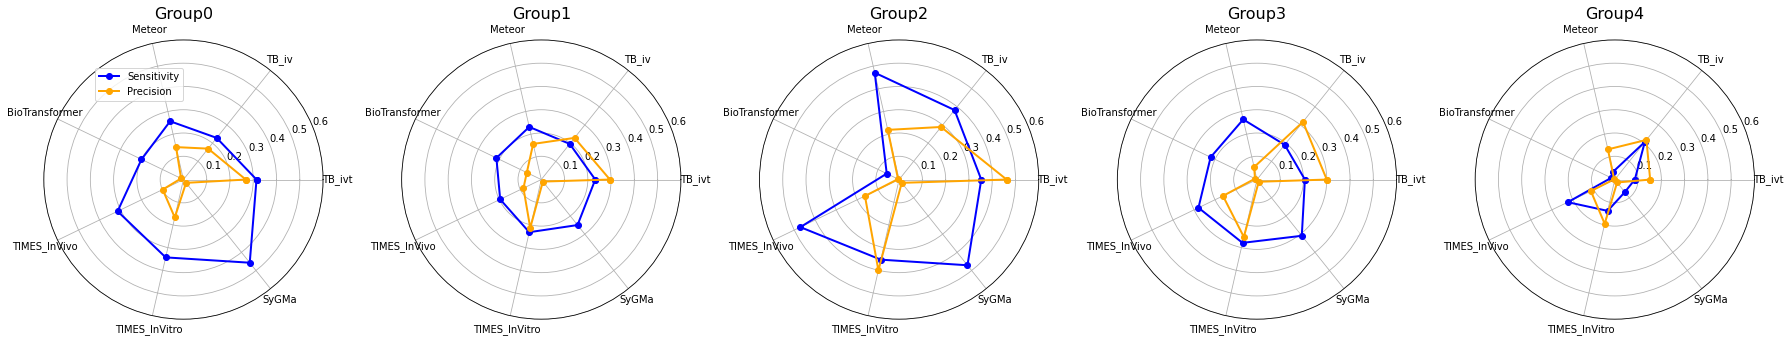

In [27]:
fig = plt.figure(figsize = (25, 5))
for idx, k in enumerate(performanceMap.keys()):
    currDF = performanceMap[k]
    labels=np.array(modelList[:-1])
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))

    precision = currDF.Precision[:-1]
    precisionForPlot = np.concatenate((precision,[precision[0]]))

    sensitivity = currDF.Sensitivity[:-1]
    sensitivityForPlot = np.concatenate((sensitivity,[sensitivity[0]]))    

    ax1 = fig.add_subplot(100 + 10*len(performanceMap.keys()) + idx + 1, polar=True)
    ax1.set_title(k, fontsize = 16)
    ax1.set_thetagrids(angles[:-1] * 180/np.pi, labels)
    ax1.set_ylim([0,0.6])
    sensitivityPlot, =  ax1.plot(angles, sensitivityForPlot, 'o-', linewidth=2, color = 'blue', label = 'Sensitivity')
    precisionPlot, =  ax1.plot(angles, precisionForPlot, 'o-', linewidth=2, color = 'orange', label = 'Precision')
    
    if(idx == 0): ax1.legend(handles = [sensitivityPlot, precisionPlot], bbox_to_anchor=(0.5, .9), loc=1, borderaxespad=0.)
        
plt.tight_layout()
plt.savefig(figures_dir+'local_comparison_Radar_031221.png', transparent = True)